<a href="https://colab.research.google.com/github/TimothyJan/Autoencoder-Movie-Recommender/blob/main/Autoencoder_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spring 2022 - CPSC 585-section-13883
Project 5 - Autoencoder Movie Recommender
Sean Javiya
Timothy Jan
Timothy Kheang

In Project 5, we apply autoencoders to the task of making movie recommendations.

Goals for this project are:
<ul>
  <li>Examining how autoencoders can be used for recommendation.</li>
  <li>Understanding the connection between autoencoders and embedding.</li>
  <li>Implementing basic, deep, and variational autoencoders.</li>
  <li>Evaluating recommender performance.</li>
</ul>


We begin with the Keras example <a href="https://keras.io/examples/structured_data/collaborative_filtering_movielens/">Collaborative Filtering for Movie Recommendations</a>. 

This example demonstrates <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">Collaborative filtering</a> using the <a href="https://www.kaggle.com/c/movielens-100k">Movielens dataset</a> to recommend movies to users. The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies. Our goal is to be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user. 

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

<h1>Load the data and apply preprocessing</h1>

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


Preprocessing to encode users and movies as integer indices.

In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


<h1>Prepare training and validation data</h1>

In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

<h1>Create the model</h1>
We embed both users and movies in to 50-dimensional vectors.<br>
The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).<br>
We are using Embedding layer instead of a single Dense hidden layer because Embedding layers work well with sparse data(e.g. where users have not rated most movies in the dataset)

In [5]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


first_model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
first_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<h1>Train the model based on the data split</h1>

In [6]:
history = first_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 20s 8ms/step - loss: 0.6358 - val_loss: 0.6206
Epoch 2/5
1418/1418 [==============================] - 11s 7ms/step - loss: 0.6135 - val_loss: 0.6175
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6088 - val_loss: 0.6143
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6079 - val_loss: 0.6128
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6071 - val_loss: 0.6129


<h1>Plot training and validation loss</h1>

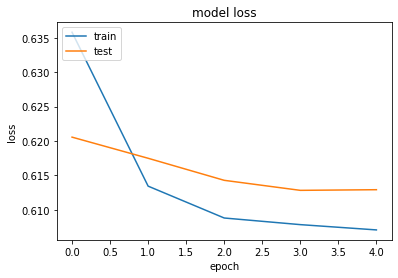

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

<h1>Show top 10 movie recommendations to a user</h1>

In [8]:
def showRecommendationsUser(model, user_id= df.userId.sample(1).iloc[0]):
  movie_df = pd.read_csv(movielens_dir / "movies.csv")
# Let us get a user and see the top recommendations.
  movies_watched_by_user = df[df.userId == user_id]
  movies_not_watched = movie_df[
      ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
  ]["movieId"]
  movies_not_watched = list(
      set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
  )
  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
  user_encoder = user2user_encoded.get(user_id)
  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [
      movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]
  print("Showing recommendations for user: {}".format(user_id))
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)
  top_movies_user = (
      movies_watched_by_user.sort_values(by="rating", ascending=False)
      .head(5)
      .movieId.values
  )
  movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
  for row in movie_df_rows.itertuples():
      print(row.title, ":", row.genres)
  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ":", row.genres)

In [9]:
showRecommendationsUser(model= first_model, user_id= 420)

Showing recommendations for user: 420
Movies with high ratings from user
--------------------------------
Singin' in the Rain (1952) : Comedy|Musical|Romance
Some Like It Hot (1959) : Comedy|Crime
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Super Size Me (2004) : Comedy|Documentary|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Silence of the Lambs, The (1991) : Crime|Horror|Thriller
Fargo (1996) : Comedy|Crime|Drama|Thriller
Godfather, The (1972) : Crime|Drama
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Casablanca (1942) : Drama|Romance
Jules and Jim (Jules et Jim) (1961) : Drama|Romance
Snatch (2000) : Comedy|Crime|Thriller


recommends for TJ

In [10]:
def showRecommendationsTJ(model):
  tj_movie_ID = [121231, 122900, 122902, 122904, 122906, 122912, 122916, 122918, 122920, 122922, 125916, 128360, 131739, 134130, 134853, 140715, 140956, 159858, 161354, 161594, 162082, 163645, 164367, 166024, 166528, 167370, 168248, 168252, 168366, 174053, 174055, 176101, 177285, 177593, 177763, 177765, 179401, 179819, 180031, 180985, 182715, 183635, 184471, 185029, 185135, 185585, 187031, 187593, 189713, 188189, ]
  tj_movie_ratings = [2.5, 3.5, 2.5, 3.75, 4.25, 4.25, 4.25, 3.5, 3.75, 3.25, 1.5, 4, 3.75, 4, 3.5, 3.75, 4, 3.75, 3.75, 4.25, 4.5, 4.25, 4.5, 4, 3.75, 0.5, 4.25, 3.5, 2, 4, 2.5, 3, 3.25, 4, 4, 3.5, 3, 3, 4.25, 3, 4, 2, 2.5, 4.5, 4.25, 4, 2.5, 3.5, 3.5, 4.5, ]
  tj_dict = {'movieId': tj_movie_ID, 'rating':tj_movie_ratings}
  movies_watched_by_tj = pd.DataFrame(tj_dict)
  movie_df = pd.read_csv(movielens_dir / "movies.csv")

  movies_not_watched_by_tj = movie_df[
      ~movie_df["movieId"].isin(movies_watched_by_tj.movieId.values)
  ]["movieId"]
  movies_not_watched_by_tj = list(
      set(movies_not_watched_by_tj).intersection(set(movie2movie_encoded.keys()))
  )
  movies_not_watched_by_tj = [[movie2movie_encoded.get(x)] for x in movies_not_watched_by_tj]
  user_encoder = 609 #must be in range, does not affect prediction. tested
  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched_by_tj), movies_not_watched_by_tj)
  )
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [
      movie_encoded2movie.get(movies_not_watched_by_tj[x][0]) for x in top_ratings_indices
  ]
  print("Showing recommendations for user: TJ")
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)
  top_movies_user = (
      movies_watched_by_tj.sort_values(by="rating", ascending=False)
      .head(5)
      .movieId.values
  )
  movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
  for row in movie_df_rows.itertuples():
      print(row.title, ":", row.genres)
  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ":", row.genres)

In [11]:
showRecommendationsTJ(first_model)

Showing recommendations for user: TJ
Movies with high ratings from user
--------------------------------
Kingsglaive: Final Fantasy XV (2016) : Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
Train to Busan (2016) : Action|Thriller
The Girl with All the Gifts (2016) : Drama|Horror|Sci-Fi|Thriller
A Quiet Place (2018) : Drama|Horror|Thriller
Sorry to Bother You (2018) : Comedy|Fantasy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Forrest Gump (1994) : Comedy|Drama|Romance|War
Godfather, The (1972) : Crime|Drama
Rear Window (1954) : Mystery|Thriller
Casablanca (1942) : Drama|Romance
Goodfellas (1990) : Crime|Drama
Cool Hand Luke (1967) : Drama
Fight Club (1999) : Action|Crime|Drama|Thriller


yes, good recommendations actually

PART 3

In [12]:
EMBEDDING_SIZE = 50

class improvedRecommender(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(improvedRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.user_movie_relationship1 = tf.keras.layers.Dense(100, activation= "relu")# use_bias= False)#, input_shape = (64,)
        self.user_movie_relationship2 = tf.keras.layers.Dense(50, activation= "relu")# use_bias= False)#, input_shape = (64,)
        self.output_layer = tf.keras.layers.Dense(1, activation= "sigmoid", input_shape= (50,))#, use_biase=False)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        
        concat_inputs = tf.concat([user_vector, movie_vector], 1)
        concat_bias = user_bias + movie_bias
        response = self.user_movie_relationship1(concat_inputs)
        response = self.user_movie_relationship2(response)
        response = response + concat_bias
        response = self.output_layer(response)
        return response


new_model = improvedRecommender(num_users, num_movies, EMBEDDING_SIZE)
new_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = new_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6053 - val_loss: 0.6013
Epoch 2/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.5900 - val_loss: 0.6009
Epoch 3/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.5804 - val_loss: 0.6028
Epoch 4/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.5695 - val_loss: 0.6060
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.5600 - val_loss: 0.6109


predict for sample data

In [14]:
showRecommendationsUser(model= new_model, user_id= 420)

Showing recommendations for user: 420
Movies with high ratings from user
--------------------------------
Singin' in the Rain (1952) : Comedy|Musical|Romance
Some Like It Hot (1959) : Comedy|Crime
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Super Size Me (2004) : Comedy|Documentary|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Chungking Express (Chung Hing sam lam) (1994) : Drama|Mystery|Romance
Wallace & Gromit: A Close Shave (1995) : Animation|Children|Comedy
It Happened One Night (1934) : Comedy|Romance
Adventures of Robin Hood, The (1938) : Action|Adventure|Romance
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Cool Hand Luke (1967) : Drama
Last Tango in Paris (Ultimo tango a Parigi) (1972) : Drama|Romance
Adam's Rib (1949) : Comedy|Romance
Dogville (2003) : Drama|Mystery|Thriller
Into

predict for TJ data

In [15]:
showRecommendationsTJ(new_model)

Showing recommendations for user: TJ
Movies with high ratings from user
--------------------------------
Kingsglaive: Final Fantasy XV (2016) : Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
Train to Busan (2016) : Action|Thriller
The Girl with All the Gifts (2016) : Drama|Horror|Sci-Fi|Thriller
A Quiet Place (2018) : Drama|Horror|Thriller
Sorry to Bother You (2018) : Comedy|Fantasy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Cinema Paradiso (Nuovo cinema Paradiso) (1989) : Drama
Rosencrantz and Guildenstern Are Dead (1990) : Comedy|Drama
Verdict, The (1982) : Drama|Mystery
My Dinner with André (1981) : Drama
Dog Soldiers (2002) : Action|Horror
Memories of Murder (Salinui chueok) (2003) : Crime|Drama|Mystery|Thriller
Bittersweet Life, A (Dalkomhan insaeng) (2005) : Action|Crime|Drama
Only Lovers Left Alive (2013) : Drama|Horror|Romance
Crippled Avengers (Can que) (Return of the 5 Deadly Venoms) (1981) : Action|Adventure
Tokyo T

at the time of writin this, the number one recommendation is my favorite movie (which I neglected to add/rate to the input sample data)

a handful of my favorite movies i neglected to add/rate are consistently in the top 5 recommendations.

PART 5

In [16]:
EMBEDDING_SIZE = 50

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the embedded user-movie inputs."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class improvedRecommenderWithAutoEncoder(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(improvedRecommenderWithAutoEncoder, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.user_movie_relationship1 = tf.keras.layers.Dense(50, activation= "relu")
        #self.user_movie_relationship2 = tf.keras.layers.Dense(50, activation= "relu")
        self.output_layer = tf.keras.layers.Dense(1, activation= "sigmoid", input_shape= (50,))

        self.DenseSamplerZmean = tf.keras.layers.Dense(10, name="z_mean")
        self.DenseSamplerZlogvar = tf.keras.layers.Dense(10, name="z_log_var")
        self.Sampling = Sampling()

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        
        concat_inputs = tf.concat([user_vector, movie_vector], 1)
        concat_bias = user_bias + movie_bias
        
        z_mean = self.DenseSamplerZmean(concat_inputs)
        z_log_var = self.DenseSamplerZlogvar(concat_inputs)
        response = self.Sampling([z_mean, z_log_var])

        #response = self.user_movie_relationship1(concat_inputs)
        response = self.user_movie_relationship1(response)
        #response = self.user_movie_relationship2(response)
        response = response + concat_bias
        response = self.output_layer(response)
        return response
    

final_model = improvedRecommenderWithAutoEncoder(num_users, num_movies, EMBEDDING_SIZE)
final_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


^complete this first

In [17]:
history = final_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6149 - val_loss: 0.6066
Epoch 2/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.5967 - val_loss: 0.6034
Epoch 3/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.5924 - val_loss: 0.6023
Epoch 4/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.5897 - val_loss: 0.6021
Epoch 5/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.5874 - val_loss: 0.6021


In [18]:
showRecommendationsUser(model= final_model, user_id= 420)

Showing recommendations for user: 420
Movies with high ratings from user
--------------------------------
Singin' in the Rain (1952) : Comedy|Musical|Romance
Some Like It Hot (1959) : Comedy|Crime
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Super Size Me (2004) : Comedy|Documentary|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
World of Apu, The (Apur Sansar) (1959) : Drama
Godfather, The (1972) : Crime|Drama
Secrets & Lies (1996) : Drama
Streetcar Named Desire, A (1951) : Drama
Train of Life (Train de vie) (1998) : Comedy|Drama|Romance|War
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Bad Boy Bubby (1993) : Drama
Captain Fantastic (2016) : Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


In [19]:
showRecommendationsTJ(final_model)

Showing recommendations for user: TJ
Movies with high ratings from user
--------------------------------
Kingsglaive: Final Fantasy XV (2016) : Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
Train to Busan (2016) : Action|Thriller
The Girl with All the Gifts (2016) : Drama|Horror|Sci-Fi|Thriller
A Quiet Place (2018) : Drama|Horror|Thriller
Sorry to Bother You (2018) : Comedy|Fantasy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Paths of Glory (1957) : Drama|War
Bridge on the River Kwai, The (1957) : Adventure|Drama|War
Kolya (Kolja) (1996) : Comedy|Drama
Lifeboat (1944) : Drama|War
Jules and Jim (Jules et Jim) (1961) : Drama|Romance
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Belle époque (1992) : Comedy|Romance
Inside Job (2010) : Documentary
Captain Fantastic (2016) : Drama


it usually will have one of the movies i really like that i neglected to add/rate in the top 5 (shawshank, pulp fiction, godfather, starwars, clockwork orange is usually correctly in the top 5)

havent seen most of the other recommendations though, but judging by imdb pages and movie category, they are good recommendations.
